The goal of this notebook is to show that the temporal aspect can be leveraged in a better way. 
Specifically, we want to show that if we consider two opposite causal directions, when we start conditioning on markov blanket members, one of the two directions mutual information will start to decrease, while the other one will keep stable (if not increase). 

In [45]:
N_VARS = 5
NOISE_STD = 0.1
MAXLAGS = 4
N_JOBS = 40

In [40]:
import networkx as nx
from d2c.data_generation.utils import show_DAG
from d2c.descriptors import D2C, DataLoader

In [67]:
from scipy.linalg import inv
import numpy as np

def mutual_information_gaussian(X,Y, Z=None): 
    """
    Compute the mutual information between two random variables X and Y
    given a conditioning variable Z using Gaussian copula.

    Parameters
    ----------
    X : np.ndarray
        The first random variable
    Y : np.ndarray
        The second random variable
    Z : np.ndarray
        The conditioning random variable (default is None)   
    """

    if Z is not None: #conditional mutual information
        
        data = np.vstack([X, Y, Z]).T  # Stack the variables together
        cov_matrix = np.cov(data, rowvar=False)

        # Compute the inverse covariance (precision matrix)
        prec_matrix = inv(cov_matrix)

        # Compute the partial correlation between X and Y given Z
        rho = -prec_matrix[0, 1] / np.sqrt(prec_matrix[0, 0] * prec_matrix[1, 1])

        # Conditional mutual information from partial correlation
        mutual_information = -0.5 * np.log(1 - rho**2)
    
    else: #mutual information

        #3: Compute correlation and mutual information
        rho = np.corrcoef(X, Y)[0, 1]

        # Mutual information from correlation
        mutual_information = -0.5 * np.log(1 - rho**2)

    return mutual_information, rho

def compute_cmi_both_directions(X, Y, shift=1):
    """
    Computes the mutual information between X[t-1] and Y, 
    the conditional mutual information between X[t-1] and Y given Y[t-1], 
    the mutual information between Y[t-1] and X,
    and the conditional mutual information between Y[t-1] and X given X[t-1]
    """


    # Let's assume Z = Y lagged (i.e., Y[t-1])

    Xt_1 = np.roll(X, shift=shift)  # a lagged version of X (shifted by 1 time step)
    Xt_1[0] = 0  # Handle the first element
    Yt_1 = np.roll(Y, shift=shift)  # a lagged version of X (shifted by 1 time step)
    Yt_1[0] = 0  # Handle the first element

    mi_causal, rho_xy_causal = mutual_information_gaussian(Xt_1,Y)
    cmi_causal, rho_xy_given_z_causal = mutual_information_gaussian(Xt_1,Y,Yt_1)

    mi_noncausal, rho_xy_noncausal  = mutual_information_gaussian(Yt_1, X)
    cmi_noncausal, rho_xy_given_z_noncausal = mutual_information_gaussian(Yt_1, X, Xt_1)

    return mi_causal, cmi_causal, mi_noncausal, cmi_noncausal, rho_xy_causal, rho_xy_given_z_causal, rho_xy_noncausal, rho_xy_given_z_noncausal

def plot_deltas_boxplot(deltas_causal, deltas_noncausal, title=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Combine the data into a single list or array
    all_deltas = deltas_causal + deltas_noncausal
    labels = ['MI(X[t-1],Y) - MI(X[t-1],Y | Y[t-1])'] * len(deltas_causal) + ['MI(Y[t-1],X) - MI(Y[t-1],X | X[t-1])'] * len(deltas_noncausal)

    # Create boxplot
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=labels, y=all_deltas, showfliers=False)
    plt.xticks(rotation=-90)
    plt.xlabel('Direction')

    plt.ylabel('Delta')
    plt.title(title)
    plt.show()

def compute_deltas_and_make_boxplot(time_series_collection, plot_title=None, filename=None):
    deltas_causal = []
    deltas_noncausal = []
    for X, Y in time_series_collection.values():
        mi_causal, cmi_causal, mi_noncausal, cmi_noncausal, _,_,_,_ = compute_cmi_both_directions(X, Y)
        delta_causal = mi_causal - mi_noncausal
        delta_noncausal = cmi_causal - cmi_noncausal
        deltas_causal.append(delta_causal)
        deltas_noncausal.append(delta_noncausal)
    
    if filename:
        np.savez(filename, deltas_causal=deltas_causal, deltas_noncausal=deltas_noncausal)

    plot_deltas_boxplot(deltas_causal, deltas_noncausal, plot_title)

## Case 1: bivariate, linear, gaussian, ARX(1)

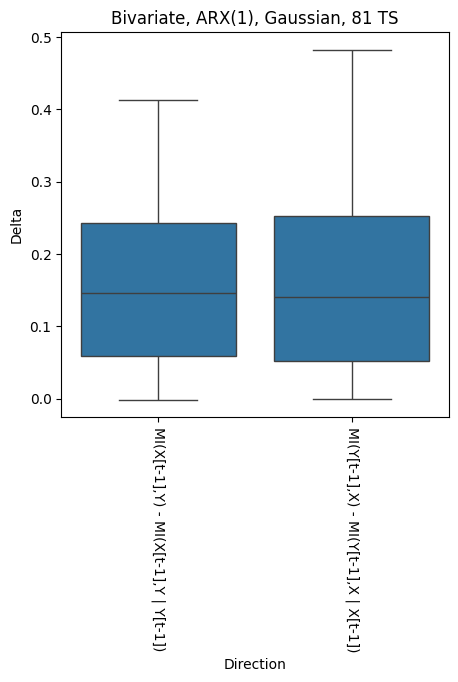

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1000  # Length of the time series
std_noise = NOISE_STD  # Standard deviation of noise

# Values of alphas and betas to iterate over
alphas =  np.arange(0.1, 1, 0.1) # AR(1) coefficients
betas =  np.arange(0.1, 1, 0.1) # Causal effects of X on Y

# Dictionary to store the time series for different alphas and betas
time_series_collection = {}

# Loop over all combinations of alphas and betas
for alpha in alphas:
    for beta in betas:
        # Generate exogenous input time series X with AR(1)
        X = np.zeros(T)
        X[0] = np.random.normal(0, 1)
        for t in range(1, T):
            X[t] = alpha * X[t-1] + np.random.normal(0, std_noise)

        # Generate causal time series Y with ARX(1) relationship to X
        Y = np.zeros(T)
        Y[0] = np.random.normal(0, 1)
        for t in range(1, T):
            Y[t] = alpha * Y[t-1] + beta * X[t-1] + np.random.normal(0, std_noise)

        # Store the time series for the current (alpha, beta) pair
        time_series_collection[(alpha, beta)] = (X, Y)

# Now, time_series_collection contains all the generated time series for different alphas and betas
compute_deltas_and_make_boxplot(time_series_collection, plot_title=f'Bivariate, ARX(1), Gaussian, {len(time_series_collection)} TS')

In [56]:

a,b,c,d, e,f,g,h = compute_cmi_both_directions(*time_series_collection[(0.2, 0.2)])
print("MI Causal:", a, 'Rho XY:', e)
print("CMI Causal:", b, 'Rho XY|Z:', f)
print("MI Non-causal:", c, 'Rho YX:', g)
print("CMI Non-causal:", d, 'Rho YX|Z:', h)

#dataframe
import pandas as pd
df = pd.DataFrame(columns=['alpha', 'beta', 'MI Causal', 'CMI Causal', 'MI Non-causal', 'CMI Non-causal', 'Rho XY', 'Rho XY|Z', 'Rho YX', 'Rho YX|Z'])
for (alpha, beta), (X, Y) in time_series_collection.items():
    mi_causal, cmi_causal, mi_noncausal, cmi_noncausal, e,f,g,h = compute_cmi_both_directions(X, Y)
    df = df.append({'alpha': alpha, 'beta': beta, 'MI Causal': mi_causal, 'CMI Causal': cmi_causal, 'MI Non-causal': mi_noncausal, 'CMI Non-causal': cmi_noncausal, 'Rho XY': e, 'Rho XY|Z': f, 'Rho YX': g, 'Rho YX|Z': h}, ignore_index=True)
    

MI Causal: 0.01205017495927344 Rho XY: 0.15431220145554744
CMI Causal: 0.009872652873388838 Rho XY|Z: 0.13982719309599442
MI Non-causal: 9.419835853088624e-05 Rho YX: 0.013725121912562475
CMI Non-causal: 1.2099014938560074e-05 Rho YX|Z: -0.004919119545931731


/tmp/ipykernel_31722/3208244360.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'alpha': alpha, 'beta': beta, 'MI Causal': mi_causal, 'CMI Causal': cmi_causal, 'MI Non-causal': mi_noncausal, 'CMI Non-causal': cmi_noncausal, 'Rho XY': e, 'Rho XY|Z': f, 'Rho YX': g, 'Rho YX|Z': h}, ignore_index=True)
/tmp/ipykernel_31722/3208244360.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'alpha': alpha, 'beta': beta, 'MI Causal': mi_causal, 'CMI Causal': cmi_causal, 'MI Non-causal': mi_noncausal, 'CMI Non-causal': cmi_noncausal, 'Rho XY': e, 'Rho XY|Z': f, 'Rho YX': g, 'Rho YX|Z': h}, ignore_index=True)
/tmp/ipykernel_31722/3208244360.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = d

In [59]:
# random 10 samples
df.sample(10)

,alpha,beta,MI Causal,CMI Causal,MI Non-causal,CMI Non-causal,Rho XY,Rho XY|Z,Rho YX,Rho YX|Z
35,0.4,0.9,0.321424,0.286089,0.005093,0.000448,0.688627,0.660079,0.100667,-0.029913
69,0.8,0.7,0.399204,0.332899,0.128775,0.000647,0.741590,0.697235,0.476504,-0.035952
3,0.1,0.4,0.069785,0.069201,0.000946,0.001070,0.360925,0.359515,-0.043468,-0.046235
57,0.7,0.4,0.248244,0.116797,0.087483,0.004043,0.625568,0.456417,0.400642,0.089739
0,0.1,0.1,0.003512,0.002401,0.000895,0.000340,0.083658,0.069212,0.042291,0.026074
48,0.6,0.4,0.127802,0.093542,0.006664,0.001088,0.474922,0.413069,0.115061,-0.046622
64,0.8,0.2,0.145687,0.051224,0.066696,0.000279,0.502756,0.312049,0.353381,0.023626
12,0.2,0.4,0.072968,0.073081,0.000850,0.000626,0.368492,0.368758,0.041212,0.035367
71,0.8,0.9,0.428286,0.492387,0.134351,0.001382,0.758541,0.791503,0.485416,-0.052537
19,0.3,0.2,0.020875,0.026567,0.000012,0.000130,0.202216,0.227481,0.004953,0.016142


# Case 2: trivariate, linear, gaussian, ARX(1)

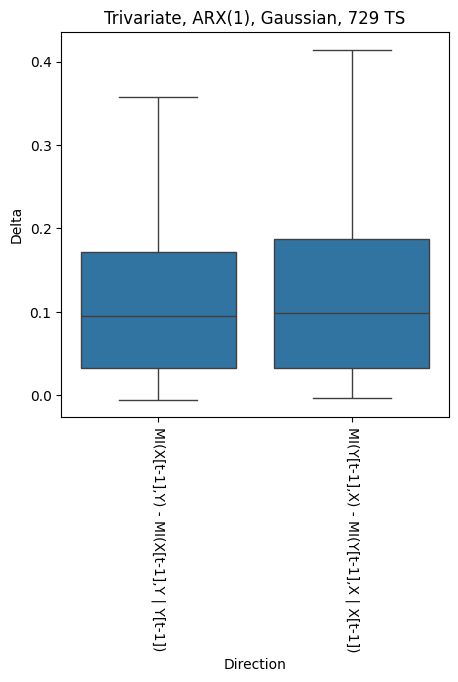

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1000  # Length of the time series
std_noise = NOISE_STD  # Standard deviation of noise

# Values of alphas and betas to iterate over
alphas =  np.arange(0.1, 1, 0.1) # AR(1) coefficients
betas =  np.arange(0.1, 1, 0.1) # Causal effects of X on Y
gammas =  np.arange(0.1, 1, 0.1) # Causal effects of Z on Y

# Dictionary to store the time series for different alphas and betas
time_series_collection = {}

# Loop over all combinations of alphas and betas
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            # Generate exogenous input time series X with AR(1)
            X = np.zeros(T)
            X[0] = np.random.normal(0, 1)
            for t in range(1, T):
                X[t] = alpha * X[t-1] + np.random.normal(0, std_noise)

            Z = np.zeros(T)
            Z[0] = np.random.normal(0, 1)
            for t in range(1, T):
                Z[t] = alpha * Z[t-1] + np.random.normal(0, std_noise)

            # Generate causal time series Y with ARX(1) relationship to X
            Y = np.zeros(T)
            Y[0] = np.random.normal(0, 1)
            for t in range(1, T):
                Y[t] = alpha * Y[t-1] + beta * X[t-1] + gamma * Z[t-1] + np.random.normal(0, std_noise)

            # Store the time series for the current (alpha, beta) pair
            time_series_collection[(alpha, beta, gamma)] = (X, Y)

# Now, time_series_collection contains all the generated time series for different alphas and betas
compute_deltas_and_make_boxplot(time_series_collection, plot_title=f'Trivariate, ARX(1), Gaussian, {len(time_series_collection)} TS')

# Case 3: trivariate, linear, gaussian, ARX(2)

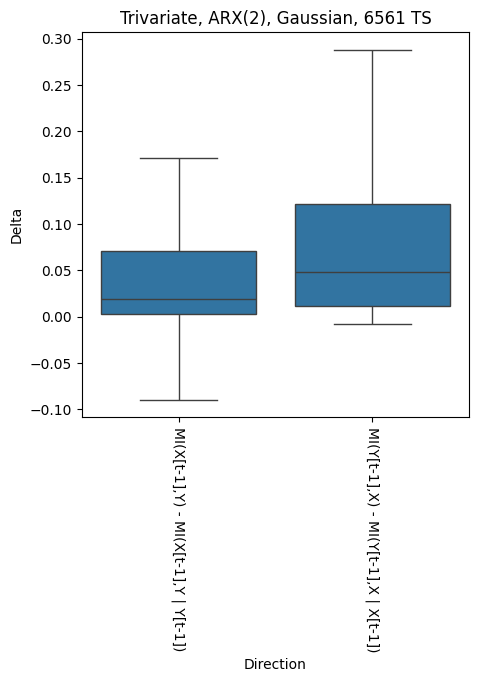

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1000  # Length of the time series
std_noise = NOISE_STD  # Standard deviation of noise

# Values of alphas and betas to iterate over
alphas_1 =  np.arange(0.1, 1, 0.1) # AR(1) coefficients
alphas_2 =  np.arange(0.1, 1, 0.1) # AR(2) coefficients
betas =  np.arange(0.1, 1, 0.1) # Causal effects of X on Y
gammas =  np.arange(0.1, 1, 0.1) # Causal effects of Z on Y

# Dictionary to store the time series for different alphas and betas
time_series_collection = {}

# Loop over all combinations of alphas and betas
for alpha_1 in alphas_1:
    for alpha_2 in alphas_2:
        for beta in betas:
            for gamma in gammas:
                # Generate exogenous input time series X with AR(1)
                X = np.zeros(T)
                X[0] = np.random.normal(0, 1)
                for t in range(1, T):
                    X[t] = alpha_1 * X[t-1] - alpha_2 * X[t-2] + np.random.normal(0, std_noise)

                Z = np.zeros(T)
                Z[0] = np.random.normal(0, 1)
                for t in range(1, T):
                    Z[t] = alpha_1 * Z[t-1] - alpha_2 * Z[t-2] + np.random.normal(0, std_noise)

                # Generate causal time series Y with ARX(1) relationship to X
                Y = np.zeros(T)
                Y[0] = np.random.normal(0, 1)
                for t in range(1, T):
                    Y[t] = alpha_1 * Y[t-1] - alpha_2 * Y[t-2] -  beta * X[t-1] - gamma * Z[t-1] + np.random.normal(0, std_noise)

                # Store the time series for the current (alpha, beta) pair
                time_series_collection[(alpha_1, alpha_2, beta, gamma)] = (X, Y)

# Now, time_series_collection contains all the generated time series for different alphas and betas
compute_deltas_and_make_boxplot(time_series_collection, plot_title=f'Trivariate, ARX(2), Gaussian, {len(time_series_collection)} TS')

In [ ]:
compute_deltas_and_make_boxplot(time_series_collection, plot_title=f'Trivariate, ARX(2), Gaussian, {len(time_series_collection)} TS')


In [110]:
dataloader = DataLoader(n_variables = N_VARS,
                    maxlags = MAXLAGS)
# dataloader.from_tsbuilder(tsbuilder)
dataloader.from_pickle('/home/gpaldino/data.pkl')


original_observations = dataloader.get_original_observations()
lagged_flattened_observations = dataloader.get_observations()
flattened_dags = dataloader.get_dags()

## Useful functions
We now write a function to get the true markov blanket of a variable in a specified dag

In [65]:
def return_mb(dag, variable_name, subset=None):
    parents = list(dag.predecessors(variable_name))
    children = list(dag.successors(variable_name))
    spouses = [list(dag.predecessors(child)) for child in children]
    spouses = [item for sublist in spouses for item in sublist]
    if subset is None:
        mb = set(parents + children + spouses)
    elif subset == 'parents':
        mb = set(parents)
    elif subset == 'children':
        mb = set(children)
    elif subset == 'spouses':
        mb = set(spouses)
    if variable_name in mb:
        mb.remove(variable_name)
    return list(mb)


## The idea
Let's consider the first DAG

In [5]:
one_obs = original_observations[0]
one_lagged_obs = lagged_flattened_observations[0]
one_dag = flattened_dags[0]

In [ ]:
show_DAG(one_dag, N_VARS, MAXLAGS)

Let's consider on the first two variables and in particular on the causal relationship between variable 0 and variable 1. <br> 
We can see from the DAG that 1 --> 0 but 0 -/->1. Now if we focus specifically on lagged couples 11 --> 5 and 10 -/->6, we should be able to show the following: <br>

$I(11,5 | x)$ will not decrease by increasing the conditioning set <br>
$I(10,6 | x)$ will decrease by increasing the conditioning set <br>


## First experiment: conditioning only on the parent of the effect 
We condition on the antecedent of the presumed effect, i.e., if you test x(t-1) -> y(t) conditioning on y(t-1) should not decrease I(x(t-1);y(t)| y(t-1)) relative to I(x(t-1);y(t)) if the causal link exists 

As a Mutual Information estimator we adopt CMIknn 

In [92]:
# ! git clone https://github.com/omesner/knncmi.git
# ! cd knncmi && pip install .
# ! cd ..
# ! rm -rf knncmi

# we won't compute the full descriptors set but we still need the estimators for Mutual Information
from d2c.descriptors.estimators import MutualInformationEstimator
mutual_information_estimator = MutualInformationEstimator() # default: estimator using Ridge
# cmi = mutual_information_estimator.estimate_original
cmi = mutual_information_estimator.estimate_knn_cmi


In [ ]:
show_DAG(one_dag, N_VARS, MAXLAGS)

In [ ]:
one_dag.edges

In [ ]:
one_lagged_obs.shape

In [ ]:
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import itertools

# Function to compute delta for causal and non-causal edges
def compute_deltas(position_index):
    verbose = False  # Set to True if you want to print verbose output
    deltas_causal = []
    deltas_noncausal = []

    one_obs = original_observations[position_index]
    one_lagged_obs = lagged_flattened_observations[position_index]
    one_dag = flattened_dags[position_index]

    for edge in one_dag.edges:
        source, target = edge
        if (source - target) % N_VARS == 0:
            continue  # parent -> child of the same variable

        opposite_source = target + N_VARS
        opposite_target = source - N_VARS

        if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS + 1):
            continue

        if verbose:
            print(f"Edge {source} -> {target}")

        # Compute deltas for causal edge
        parent_of_putative_effect = target + N_VARS
        if parent_of_putative_effect < N_VARS * (MAXLAGS + 1):
            before_causal = cmi(one_lagged_obs, source, target)
            after_causal = cmi(one_lagged_obs, source, target, [parent_of_putative_effect])
            delta_causal = before_causal - after_causal
            deltas_causal.append(delta_causal)

        if verbose:
            print(f"Opposite edge {opposite_source} -> {opposite_target}")

        # Compute deltas for non-causal edge
        parent_of_putative_effect = opposite_target + N_VARS
        if parent_of_putative_effect < N_VARS * (MAXLAGS + 1):
            before_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target)
            after_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target, [parent_of_putative_effect])
            delta_noncausal = before_noncausal - after_noncausal
            deltas_noncausal.append(delta_noncausal)

    return deltas_causal, deltas_noncausal

if __name__ == '__main__':
    # Determine number of processes to use (default to number of available CPUs)
    num_processes = cpu_count()

    # Create a pool of workers
    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_deltas, range(len(original_observations))), total=len(original_observations)))

    # Unpack results
    deltas_causal = []
    deltas_noncausal = []
    for result in results:
        deltas_causal.extend(result[0])
        deltas_noncausal.extend(result[1])

    # Now deltas_causal and deltas_noncausal contain the computed deltas from all processes

    # Example of how to pickle the deltas
    import pickle
    with open("/home/gpaldino/deltas_knncmi_oneparentonly.pkl", "wb") as f:
        pickle.dump((deltas_causal, deltas_noncausal), f)


In [ ]:
# from tqdm import tqdm

# # only the parent of the putative effect 
# verbose = False 
# deltas_causal = []
# deltas_noncausal = []

# for position_index in tqdm(range(len(original_observations)), total=len(original_observations)):
    
#     one_obs = original_observations[position_index]
#     one_lagged_obs = lagged_flattened_observations[position_index]
#     one_dag = flattened_dags[position_index]

#     for edge in one_dag.edges:
#         source, target = edge
#         if (source - target) % N_VARS == 0:
#             continue # parent -> child of the same variable 

#         opposite_source = target + N_VARS
#         opposite_target = source - N_VARS

#         if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS+1):
#             continue

#         if verbose: print(f"Edge {source} -> {target}")


#         # I(source, target | x)
#         parent_of_putative_effect = target + N_VARS 
#         if parent_of_putative_effect >= N_VARS * (MAXLAGS+1):
#             continue
#         before_causal = cmi(one_lagged_obs, source, target)
#         after_causal = cmi(one_lagged_obs, source, target, [parent_of_putative_effect])
#         delta_causal = before_causal - after_causal

#         deltas_causal.append(delta_causal)

#         if verbose: print(f"Opposite edge {opposite_source} -> {opposite_target}")

#         # I(opposite_source, opposite_target | x)
#         parent_of_putative_effect = opposite_target + N_VARS 
#         if parent_of_putative_effect >= N_VARS * (MAXLAGS+1):
#             continue
#         before_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target)
#         after_noncausal = cmi(one_lagged_obs, opposite_source, opposite_target, [parent_of_putative_effect])
#         delta_noncausal = before_noncausal - after_noncausal

#         deltas_noncausal.append(delta_noncausal)

# # # pickle the deltas
# # import pickle
# # with open("/home/gpaldino/deltas_knncmi_oneparentonly.pkl", "wb") as f:
# #     pickle.dump((deltas_causal,deltas_noncausal), f)



In [123]:
# load the deltas
import pickle
with open("/home/gpaldino/deltas_knncmi_oneparentonly.pkl", "rb") as f:
    deltas_causal,deltas_noncausal = pickle.load(f)


In [ ]:
# Combine the data into a single list or array
all_deltas = deltas_causal + deltas_noncausal
labels = ['Causal'] * len(deltas_causal) + ['Non-causal'] * len(deltas_noncausal)

# Create boxplot
plt.figure(figsize=(5, 5))
sns.boxplot(x=labels, y=all_deltas)
plt.ylabel('Delta between MI(a,b) and MI(a,b | parent(b))')
plt.title('Distribution of deltas between MI(a,b) and MI(a,b | parent(b)) for 720 different dags ')
plt.show()

In [ ]:
from scipy import stats

# Perform t-test
t_statistic, p_value = stats.ttest_ind(deltas_causal, deltas_noncausal)

# Print results
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference between the groups.")
else:
    print("Fail to reject null hypothesis: There is no significant difference between the groups.")

## Second experiment: conditioning on all the true parents and assessing how the mutual information changes

In [139]:
def compute_mis(one_lagged_obs, source, target, subset, verbose, only_target=False):
    """
    Computes the mutual information score (MIS) between a source and target node,
    conditioned on subsets of their Markov blankets (MBs).
    Parameters:
    source (int or str): The source node.
    target (int or str): The target node.
    subset (list): A subset of nodes to consider for the Markov blanket (only parents; only children; only spouses).
    verbose (bool): If True, prints detailed debug information.
    Returns:
    dict: A dictionary where keys are the size of the conditioning set and values
          are the corresponding conditional mutual information scores.
    """
    # I(source, target | x)
    if verbose: print(f"Edge {source} -> {target}")

    mb_source = return_mb(one_dag, source, subset=subset)
    if verbose: print(f'MB Souce {mb_source}')

    mb_target = return_mb(one_dag, target, subset=subset)
    if verbose: print(f'MB Target {mb_target}')

    if only_target:
        combined_mbs = list(set(mb_target) - {source, target}) # target parents only
    else:
        combined_mbs = list(set(mb_source + mb_target) - {source, target})


    if verbose: print(f'MB Combined {combined_mbs}')

    mutual_information_causal = {}

    single_mi = cmi(one_lagged_obs, source, target)
    if verbose: print(f'Not conditioning: {single_mi}')

    for m_idx in range(1,len(combined_mbs)+1):
        m = combined_mbs[:m_idx]
        single_mi = cmi(one_lagged_obs, source, target, m)
        if verbose: print(f'Conditioning on {m}: {single_mi}')
        mutual_information_causal[m_idx] = single_mi
    return single_mi, mutual_information_causal



In [ ]:
# PARALLEL VERSION (sequential below)

from tqdm import tqdm
from multiprocessing import Pool, cpu_count

verbose = False
SUBSET = 'parents'
mi_dags = {}

# Function to compute mi_dags for a single position_index
def compute_mi_dag(position_index):
    one_lagged_obs = lagged_flattened_observations[position_index]
    one_dag = flattened_dags[position_index]

    mi_single_dag = {}
    for edge in one_dag.edges:
        source, target = edge
        if (source - target) % N_VARS == 0:
            continue  # parent -> child of the same variable

        opposite_source = target + N_VARS
        opposite_target = source - N_VARS

        if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS + 1):
            continue

        # Compute mutual information for both directions synchronously
        single_mi_direction_one, mi_direction_one = compute_mis(one_lagged_obs, source, target, SUBSET, verbose, only_target=True)
        single_mi_direction_two, mi_direction_two = compute_mis(one_lagged_obs, opposite_source, opposite_target, SUBSET, verbose)

        mi_single_dag[(source, target)] = (single_mi_direction_one, mi_direction_one, single_mi_direction_two, mi_direction_two)

    return mi_single_dag

if __name__ == '__main__':
    # Determine number of processes to use (default to number of available CPUs)
    num_processes = cpu_count()

    # Create a pool of workers
    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_mi_dag, range(len(original_observations))), total=len(original_observations)))

    # Gather results into mi_dags
    for position_index, result in enumerate(results):
        mi_dags[position_index] = result

    # Now mi_dags contains the computed mutual informations for all position indices


In [ ]:
## SEQUENTIAL VERSION (sequential below)
# verbose = False 
# SUBSET = 'parents'
# mi_dags = {}
# for position_index in tqdm(range(len(original_observations)), total=len(original_observations)):
#     one_obs = original_observations[position_index]
#     one_lagged_obs = lagged_flattened_observations[position_index]
#     one_dag = flattened_dags[position_index]

#     mi_single_dag = {}
#     for edge in one_dag.edges:
#         source, target = edge
#         if (source - target) % N_VARS == 0:
#             continue # parent -> child of the same variable 

#         opposite_source = target + N_VARS
#         opposite_target = source - N_VARS

#         if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS+1):
#             continue

#         mi_direction_one = compute_mis(one_lagged_obs,source, target, SUBSET, verbose)
#         mi_direction_two = compute_mis(one_lagged_obs,opposite_source, opposite_target, SUBSET, verbose)

#         mi_single_dag[(source, target)] = (mi_direction_one, mi_direction_two)

#     mi_dags[position_index] = mi_single_dag

In [ ]:
flattened_dags[0].edges

In [152]:
causal_deltas_single_dag = {}
noncausal_deltas_single_dag = {}
for _, mi_dag in mi_dags.items():
    for pair, elements in mi_dag.items():
        causal_before = elements[0]
        causal_changes = elements[1]
        noncausal_before = elements[2]
        noncausal_changes = elements[3]

        causal_deltas_single_couple = {}
        for key, value in causal_changes.items():

            if key in causal_deltas_single_dag:
                causal_deltas_single_dag[key].append(causal_before - value)
            else:
                causal_deltas_single_dag[key] = [causal_before - value]

        noncausal_deltas_single_couple = {}
        for key, value in noncausal_changes.items():
                if key in noncausal_deltas_single_dag:
                    noncausal_deltas_single_dag[key].append(noncausal_before - value)
                else:
                    noncausal_deltas_single_dag[key] = [noncausal_before - value]


            


In [ ]:
causal_deltas_single_dag.keys()
noncausal_deltas_single_dag.keys()

In [ ]:
# Prepare data for boxplot
data = []
keys = set(causal_deltas_single_dag.keys()).union(set(noncausal_deltas_single_dag.keys()))

for key in keys:
    if key in causal_deltas_single_dag and key in noncausal_deltas_single_dag:
        for causal_val, noncausal_val in zip(causal_deltas_single_dag[key], noncausal_deltas_single_dag[key]):
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val
            })
            data.append({
                'key': key,
                'type': 'noncausal',
                'value': noncausal_val
            })
    elif key in causal_deltas_single_dag:
        for causal_val in causal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val
            })
    elif key in noncausal_deltas_single_dag:
        for noncausal_val in noncausal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'noncausal',
                'value': noncausal_val
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting boxplots
plt.figure(figsize=(12, 8))
plt.title('Causal vs Noncausal Delta Boxplots')

# Boxplot using seaborn
import seaborn as sns
sns.boxplot(x='key', y='value', hue='type', data=df, palette='Set3')
plt.xlabel('Elements of true target parents set added')
plt.ylabel('Delta Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind


# Prepare data for boxplot and calculate p-values
data = []
keys = set(causal_deltas_single_dag.keys()).union(set(noncausal_deltas_single_dag.keys()))

for key in keys:
    if key in causal_deltas_single_dag and key in noncausal_deltas_single_dag:
        for causal_val, noncausal_val in zip(causal_deltas_single_dag[key], noncausal_deltas_single_dag[key]):
            t_stat, p_val = ttest_ind(causal_deltas_single_dag[key], noncausal_deltas_single_dag[key])
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val,
                'p_value': p_val
            })
            data.append({
                'key': key,
                'type': 'noncausal',
                'value': noncausal_val,
                'p_value': p_val
            })
    elif key in causal_deltas_single_dag:
        for causal_val in causal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'causal',
                'value': causal_val,
                'p_value': None  # No p-value for single data points
            })
    elif key in noncausal_deltas_single_dag:
        for noncausal_val in noncausal_deltas_single_dag[key]:
            data.append({
                'key': key,
                'type': 'noncausal',
                'value': noncausal_val,
                'p_value': None  # No p-value for single data points
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting boxplots
plt.figure(figsize=(12, 8))
plt.title('Causal vs Noncausal Delta Boxplots with p-values')

# Boxplot using seaborn
import seaborn as sns
sns.boxplot(x='key', y='value', hue='type', data=df, palette='Set3')

# Annotate with p-values
for key in keys:
    causal_vals = df[(df['key'] == key) & (df['type'] == 'causal')]['value'].values
    noncausal_vals = df[(df['key'] == key) & (df['type'] == 'noncausal')]['value'].values
    p_val = df[(df['key'] == key) & (df['type'] == 'causal')]['p_value'].values[0]  # Assume p-value is the same for both causal and noncausal
    
    if p_val is not None:
        plt.text(list(keys).index(key) - 0.15, max(max(causal_vals), max(noncausal_vals)) + 0.5, f'p-value: {p_val:.4f}', fontsize=10, ha='center')

plt.xlabel('Keys')
plt.ylabel('Delta Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Experiment 3: using whole markov blanket of the target variable 

In [ ]:
# PARALLEL VERSION (sequential below)

from tqdm import tqdm
from multiprocessing import Pool, cpu_count

verbose = False
SUBSET = 'parents'
mi_dags = {}

# Function to compute mi_dags for a single position_index
def compute_mi_dag(position_index):
    one_lagged_obs = lagged_flattened_observations[position_index]
    one_dag = flattened_dags[position_index]

    mi_single_dag = {}
    for edge in one_dag.edges:
        source, target = edge
        if (source - target) % N_VARS == 0:
            continue  # parent -> child of the same variable

        opposite_source = target + N_VARS
        opposite_target = source - N_VARS

        if opposite_target < 0 or opposite_source >= N_VARS * (MAXLAGS + 1):
            continue

        # Compute mutual information for both directions synchronously
        single_mi_direction_one, mi_direction_one = compute_mis(one_lagged_obs, source, target, SUBSET, verbose)
        single_mi_direction_two, mi_direction_two = compute_mis(one_lagged_obs, opposite_source, opposite_target, SUBSET, verbose)

        mi_single_dag[(source, target)] = (single_mi_direction_one, mi_direction_one, single_mi_direction_two, mi_direction_two)

    return mi_single_dag

if __name__ == '__main__':
    # Determine number of processes to use (default to number of available CPUs)
    num_processes = cpu_count()

    # Create a pool of workers
    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(compute_mi_dag, range(len(original_observations))), total=len(original_observations)))

    # Gather results into mi_dags
    for position_index, result in enumerate(results):
        mi_dags[position_index] = result

    # Now mi_dags contains the computed mutual informations for all position indices
